In [1]:
# Instalar las librerías correspondientes para correr el proyecto
# !pip install numpy scipy matplotlib seaborn scikit-learn mesa==3.0 -q

# Sistema de Recolección de Alimentos versión teletransportarse

## Objetivo del Sistema: 
Desarrollar un sistema donde agentes llamados 'exploradores' buscan comida y la llevan de vuelta a su base. Los exploradores se desplazan buscando celdas con alimentos y regresan a la base una vez que encuentran un recurso.

## Características del Sistema:
- Energia del Explorador: Cada explorador comienza con una energía máxima de X unidades, y cada movimiento consume 1 unidad de energía. Al llegar a la base, el explorador recarga completamente su energía.

- Ubicación de la Base: La base siempre se encuentra en el centro del área de búsqueda.

- Parámetros del Sistema:   
Un área de NxN celdas.  
Un número específico de exploradores.  
Una base fija en una celda determinada.  
Un número de recursos.  
Un máximo de energía que los exploradores pueden tener.  

## Distribución de Agentes y Recursos  
Tanto los agentes como los recursos se distribuyen aleatoriamente al inicio de la simulación.  

## Comportamiento por Paso:  
- Si la celda contiene recursos, el agente los recoge y regresa a la base.  
- Si la celda no contiene recursos, el agente elige una dirección aleatoria para moverse (una de las 4 celdas vecinas) a una celda sin otro agente. Si no puede moverse allí, permanecerá en la misma celda.  

## Instrucciones para la Simulación y el Análisis
1. Simulacion inicial:  
- Ejecuta una simulación para una matriz de 11x11 con 5 exploradores y 20 recursos.  
- Todos los agentes deben empezar con 100 unidades de energía.  
- Muestra gráficamente el comportamiento del modelo.  
- Recupera, y muestra, los siguiente datos de tu simulación:  
número de pasos necesarios para recolectar todos los recursos  
cuántos recursos recuperó cada agente  
cuántas recargar totales tuvo que hacer cada agente  

## Imports

----------------------------------------------

In [2]:
from mesa import Agent, Model

from mesa.space import SingleGrid

from mesa.time import RandomActivation

from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import time
import datetime

TypeError: _TypedDictMeta.__new__() got an unexpected keyword argument 'closed'

In [ ]:
class FoodExplorerAgent(Agent):
    def __init__(self, model, _energy):
        super().__init__(model)
        self.visited_cells = 1
        self.total_recharges = 0 
        self.resource_obtained = 0
        self.max_energy = _energy
        self.energy = _energy
        self.found_food = False
        self.returning_base = False

    def move(self):
        possible_positions = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)

        options = np.random.permutation(len(possible_positions))

        for i in options:
            new_pos = possible_positions[i]
            if self.model.grid.is_cell_empty(new_pos) and self.energy > 0:
                self.model.grid.move_agent(self, new_pos)
                self.visited_cells += 1
                self.energy -= 1
                #print("Energy", self.energy)
                break

        if self.energy <= 0 and self.model.grid.is_cell_empty(self.model.base_coord):
            self.model.grid.move_agent(self, self.model.base_coord)
            self.energy = self.max_energy
            self.total_recharges += 1


    def step(self):
        (x,y) = self.pos

        # siempre que esté en base y no tenga full energía, recarga
        if self.pos == self.model.base_coord and self.energy < self.max_energy:
            self.energy = self.max_energy
            self.total_recharges += 1

        if self.model.cells[x][y] == 1:
            self.model.cells[x][y] = 0
            self.resource_obtained += 1
            self.found_food = True
            if self.model.grid.is_cell_empty(self.model.base_coord):
                self.returning_base = True
                self.model.grid.move_agent(self, self.model.base_coord)
                self.energy = self.max_energy
                self.total_recharges += 1
        else:
            self.found_food = False
            self.returning_base = False
            self.move()
            

In [ ]:
# Se usa para recuperar el estado de la simulación
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for content, (x,y) in model.grid.coord_iter():
        grid[x][y] = model.cells[x][y]  # se obtiene el estado de la celda
        if content != None:
            grid[x][y] = 2 # El 2 indica el color más oscuro (robot), 1 un gris (sucio) y el 0 un blanco (limpio)
    bx, by = model.base_coord
    grid[bx][by] = 3
    return grid

In [ ]:
class FoodExplorerModel(Model):
    def __init__ (self, width, height, num_agents, num_food, energy, base_coord):
        super().__init__()
        self.num_agents = num_agents
        self.num_food = num_food
        self.base_coord = base_coord
        
        self.grid = SingleGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)

        self.cells = np.zeros( (width, height))
        count = int((width * height * num_food))
        while count > 0:
        
            x = self.random.randrange(width)
            y = self.random.randrange(height)

            if self.cells[x][y] == 0:
                self.cells[x][y] = 1
                count -= 1

        #Crear agentes
        i = 0
        while i < num_agents:
            x = self.random.randrange(width)
            y = self.random.randrange(height)
        
            if self.grid.is_cell_empty((x,y)):
                agent = FoodExplorerAgent(self, energy)
                self.schedule.add(agent)
                self.grid.place_agent(agent, (x,y))
                i += 1

        self.steps = 0
        self.datacollector = DataCollector(
        model_reporters=
            {
                "Grid" : get_grid,
                "Steps" : lambda model : model.steps,
                "Clean" : lambda model : 1.0 - (model.cells.sum() / model.cells.size)             
            },
        agent_reporters= 
            {
                "Resources": lambda agent: agent.resource_obtained,
                "VisitedCells": lambda agent: agent.visited_cells,
                "Recharges": lambda agent: agent.total_recharges
            }
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def food_free(self):
        return self.cells.sum() == 0

In [ ]:
WIDTH = 21
HEIGHT = 21
AGENTS = 5
FOOD = 0.20
ENERGY = 100
BASE_COORD = (WIDTH // 2, HEIGHT // 2)
ITERATIONS = 1000

model = FoodExplorerModel(WIDTH, HEIGHT, AGENTS, FOOD, ENERGY, BASE_COORD)
#for i in range(ITERATIONS):
for i in range(ITERATIONS):
    model.step()

C:\Users\aleja\AppData\Local\Temp\ipykernel_18672\3913588424.py:9: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in a future version. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


In [ ]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head()

Grid  Steps     Clean
0  [[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...      1  0.800454
1  [[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...      2  0.804989
2  [[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...      3  0.804989
3  [[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...      4  0.804989
4  [[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...      5  0.804989

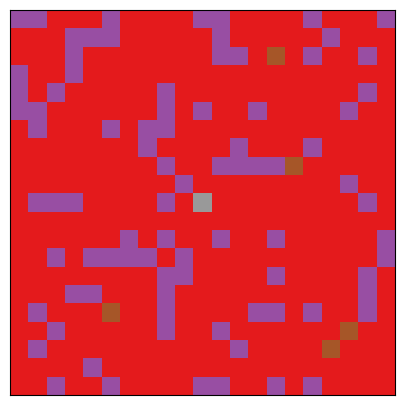

In [ ]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grids.iloc[0,0], cmap=plt.cm.Set1)

def animate(i):
    patch.set_data(all_grids.iloc[i,0])

anim = animation.FuncAnimation(fig, animate,frames=len(all_grids))

In [ ]:
anim